In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [14]:
import os
import math
from typing import List

import cv2 as cv
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
from src.config import CLASS_MAPPINGS_REVERTED, CLASS_TO_COLORS

In [5]:
CLASS_MAPPINGS_REVERTED

{1: 'adapter', 2: 'bottle', 3: 'box', 4: 'clamp', 5: 'drill', 6: 'duck'}

In [7]:
CLASS_MAPPINGS = {0: "background"}
CLASS_MAPPINGS.update(CLASS_MAPPINGS_REVERTED)

In [8]:
CLASS_MAPPINGS

{0: 'background',
 1: 'adapter',
 2: 'bottle',
 3: 'box',
 4: 'clamp',
 5: 'drill',
 6: 'duck'}

In [10]:
CLASSES_ABBREVIATIONS = {
    "background": "bg",
    "box": "bx",
    "clamp": "cl",
    "drill": "dr",
    "duck": "du", 
    "adapter": "ad",
    "bottle": "bo"
}

In [11]:
CLASS_MAPPINGS_ABBR = {}
for c_id, c_name in CLASS_MAPPINGS.items():
    CLASS_MAPPINGS_ABBR[c_id] = CLASSES_ABBREVIATIONS[c_name]

In [12]:
CLASS_MAPPINGS_ABBR

{0: 'bg', 1: 'ad', 2: 'bo', 3: 'bx', 4: 'cl', 5: 'dr', 6: 'du'}

In [9]:
CLASS_TO_COLORS

array([[127, 127, 127],
       [255,   0,   0],
       [  0, 255,   0],
       [255,   0, 255],
       [255, 255,   0],
       [  0, 255, 255],
       [249, 215,  28]])

In [72]:
SEGMENT_H = 30
SEGMENT_W = 80


def prepare_colours_mapping() -> np.ndarray:
    result = []
    for c_idx, col in enumerate(CLASS_TO_COLORS):
        segment = np.ones((SEGMENT_H, SEGMENT_W, 3), dtype=np.uint8)
        segment = (segment * col).astype(np.uint8)
        text = CLASS_MAPPINGS_ABBR[c_idx]
        (font_w, font_h), _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        half_font_w, half_font_h = int(round(font_w / 2)), int(round(font_h / 2))
        half_segment_height = int(round(SEGMENT_H / 2))
        half_segment_width = int(round(SEGMENT_W / 2))
        text_x_pos = max(half_segment_width - half_font_w, 0)
        text_y_pos = max(half_segment_height + half_font_h, 0)
        cv.putText(segment, text, (text_x_pos, text_y_pos), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        result.append(segment)
    return np.concatenate(result, axis=1)[:, :, ::-1]

In [73]:
mapping = prepare_colours_mapping()

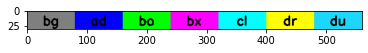

In [119]:
plt.imshow(mapping[:, :, ::-1])

In [96]:
def embed_colour_mapping_in_image(image: np.ndarray) -> np.ndarray:
    color_mapping = prepare_colours_mapping()
    if image.shape[1] < color_mapping.shape[1]:
        scale = image.shape[1] / color_mapping.shape[1]
        color_mapping = cv.resize(color_mapping, dsize=None, fx=scale, fy=scale)
    else:
        if (image.shape[1] - color_mapping.shape[1]) % 2 != 0:
            diff_l = (image.shape[1] - color_mapping.shape[1]) // 2
            diff_r = (image.shape[1] - color_mapping.shape[1]) // 2 + 1
        else:
            diff_l = diff_r = (image.shape[1] - color_mapping.shape[1]) // 2
        l_padding = np.zeros((SEGMENT_H, diff_l, 3), dtype=np.uint8)
        r_padding = np.zeros((SEGMENT_H, diff_r, 3), dtype=np.uint8)
        color_mapping = np.concatenate([l_padding, color_mapping, r_padding], axis=1)
    return np.concatenate([image, color_mapping], axis=0)

In [99]:
result = embed_colour_mapping_in_image(
    image=np.zeros((1080, 1920, 3), dtype=np.uint8)
)

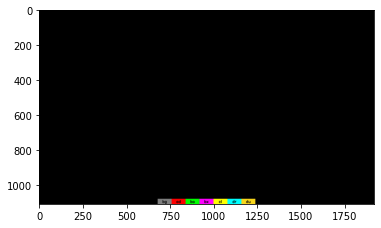

In [101]:
plt.imshow(result[:, :, ::-1])

In [107]:
result = embed_colour_mapping_in_image(
    image=np.zeros((240, 320, 3), dtype=np.uint8)
)

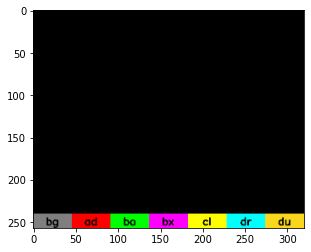

In [108]:
plt.imshow(result[:, :, ::-1])

In [130]:
ICNET_BAD_EXAMPLE = "/home/ppeczek/Dokumenty/YetAnotherSegmentationExperiment/resources/experiments/final_experiment/ic_net_ce_dice/random_split_#0/inference_results/086c20f5-8c28-4e8d-b01d-50850151b41f"

In [160]:
def load_example(example_root: str, 
                 order=["image", "gt", "prediction"],
                 append_col_mapping: bool = False
                ) -> np.ndarray:
    images = []
    for o in order:
        image = cv.imread(f"{example_root}_{o}.png")
        if o != "image":
            image = image[:, :, ::-1]
        images.append(image)
    result = np.concatenate(images, axis=1)
    if append_col_mapping:
        return embed_colour_mapping_in_image(result)
    return result

In [164]:
example = load_example(ICNET_BAD_EXAMPLE, append_col_mapping=True)

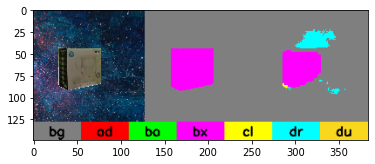

In [165]:
plt.imshow(example[:, :, ::-1])

In [134]:
cv.imwrite("icnet_bad.png", example)

True

In [143]:
BAD_BOX_EXAMPLE_ROOT = "/home/ppeczek/Dokumenty/YetAnotherSegmentationExperiment/resources/experiments/final_experiment/u_net_original_ce/rotation-based_split_#1/inference_results/4dd72127-0544-4ac7-afba-31ff6590b962"

In [161]:
bad_box = load_example(BAD_BOX_EXAMPLE_ROOT)

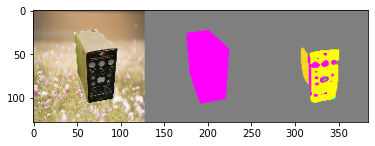

In [163]:
plt.imshow(bad_box[:, :,::-1])

In [180]:
DUCK_EXAMPLE_ROOT = "/home/ppeczek/Dokumenty/YetAnotherSegmentationExperiment/resources/experiments/final_experiment/u_net_original_ce/rotation-based_split_#1/inference_results/8f3dc1c2-99de-48c4-8661-bb2de58703c9"

In [181]:
duck_example = load_example(DUCK_EXAMPLE_ROOT)

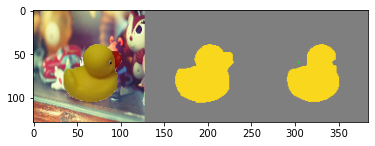

In [182]:
plt.imshow(duck_example[:, :,::-1])

In [178]:
BAD_CLAMP_PRED_ROOT = "/home/ppeczek/Dokumenty/YetAnotherSegmentationExperiment/resources/experiments/final_experiment/u_net_original_ce/rotation-based_split_#1/inference_results/41d8ad59-72bc-4ab1-9578-da1134e1cbb6"

In [183]:
bad_clamp = load_example(BAD_CLAMP_PRED_ROOT)

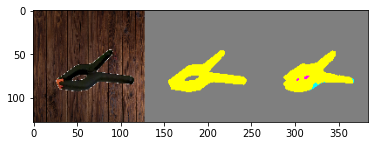

In [185]:
plt.imshow(bad_clamp[:, :,::-1])

In [188]:
distancer = np.ones((5, bad_clamp.shape[1], 3), dtype=np.uint8) *255

In [189]:
connected = np.concatenate(
    [duck_example, distancer, bad_box, distancer, bad_clamp],
    axis=0
)

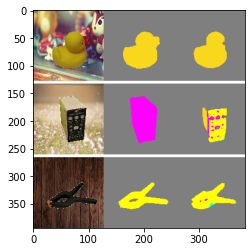

In [190]:
plt.imshow(connected[:, :, ::-1])

In [191]:
connected = embed_colour_mapping_in_image(connected)

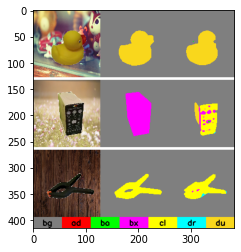

In [192]:
plt.imshow(connected[:, :, ::-1])

In [193]:
cv.imwrite("problematic_cases.png", connected)

True